### Table Content
------------------

- [Introduction](#intro)
- [Import libraries and packages](#ilp)
- [Dataset Information](#di)
- [Separate 'Title' field and preprocess it](#preprocess)
    - [Removing unwanted charaters and words](#remv)
    - [Tokenization and word_index (vocabulary) ](#token)
    - [Convert titles into sequences and Make n_gram model](#ngram)
    - [Make all titles with same length and padding them](#pad)
- [Preprare features (X) and labels (Y)](#xy)
- [Architechture of Bidirectional LSTM neural network](#blstm)
- [Train Bi-LSTM neural network](#train)
- [Plotting accuracy and loss graph](#acc)
- [Predict new title (Testing)](#new)
- [SentencePiece](#SentencePiece)

----------------




# Original version from Kaggle

<a name="intro"></a>

## Introduction

**Next Word Prediction (also called Language Modeling) is the task of predicting what word comes next. It is one of the fundamental tasks of NLP.**

Image reference: https://medium.com/@antonio.lopardo/the-basics-of-language-modeling-1c8832f21079

![gg.png](attachment:426089b0-5844-4928-a797-40e0015c1a93.png)

#### Application Language Modelling 

**1) Mobile keyboard text recommandation**

![fff.jpg](attachment:0cd813a1-ea03-40b9-86d7-0585d994a36e.jpg)

**2) Whenever we search for something on any search engine, we get many suggestions and,  as we type new words in it, we get better recommendations according to our searching context. So, how will it happen??? **

![Screenshot (21).png](attachment:72ee772e-4ef9-4e79-a364-5dcf8f558e4a.png)


It is poosible through natural language processing (NLP) technique. Here, we will use NLP and try to make a prediction model using Bidirectional LSTM (Long short-term memory) model that will predict next words of sentence.
 

<a name="ilp"></a>
## Import necessary libraries and packages 

In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

<a name="di"></a>
## Dataset information

**Import Medium-articles-dataset:**

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

- Towards Data Science
- UX Collective
- The Startup
- The Writing Cooperative
- Data Driven Investor
- Better Humans
- Better Marketing


### Kaggle version

In [ ]:
medium_data = pd.read_csv('../input/medium-articles-dataset/medium_data.csv')
medium_data.head()

### Colab version

In [ ]:
data_link = "https://drive.google.com/file/d/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8/view?usp=sharing"
file_id= data_link.split('/')[-2]
fn = 'medium_data.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=''$file_id' -O '$fn'


--2022-06-02 16:02:47--  https://docs.google.com/uc?export=download&id=1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8
Resolving docs.google.com (docs.google.com)... 142.251.107.113, 142.251.107.139, 142.251.107.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ad7or30hcd35ars5dndq0oo1g5s2dbpl/1654185750000/17304979608001708681/*/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8?e=download [following]
--2022-06-02 16:02:48--  https://doc-14-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ad7or30hcd35ars5dndq0oo1g5s2dbpl/1654185750000/17304979608001708681/*/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8?e=download
Resolving doc-14-b0-docs.googleusercontent.com (doc-14-b0-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-14-b0-docs.googleusercontent.com (doc-14-b0-docs

In [ ]:
#medium_data = pd.read_csv('../input/medium-articles-dataset/medium_data.csv') # Kaggle
medium_data = pd.read_csv('medium_data.csv') # Colab
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


Here, we have a **10 different fields and 6508 records** but we will only use **title field** for predicting next word. 

In [ ]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


<a name="preprocess"></a>
### Display titles of various articles  and preprocess them

In [ ]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

<a name="remv"></a>
#### Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

<a name="token"></a>
#### Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [ ]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


<a name="ngram"></a>
#### Titles text into sequences and make n_gram model

suppose, we have sentence like **"I am Yash"** and this will convert into a sequence with their respective tokens **{'I': 1,'am': 2,'Yash': 3}**. Thus, output will be  **[ '1' ,'2' ,'3' ]**

Likewise, our all titles will be converted into sequences.

Then,
we will make a n_gram model for good prediction.

Below image explain about everything.

![Capture.PNG](attachment:48ad80b3-90bf-4cf6-99f8-7dcfd467d1f8.PNG)


In [ ]:
input_sequences = []
for c, line in enumerate(medium_data['title']):
    token_list = tokenizer.texts_to_sequences([line])[0]
    if c< 2: print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

    if c< 2: print(input_sequences)
print("Total input sequences: ", len(input_sequences))

[5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99]
[[5, 676], [5, 676, 68], [5, 676, 68, 2], [5, 676, 68, 2, 452], [5, 676, 68, 2, 452, 1518], [5, 676, 68, 2, 452, 1518, 14], [5, 676, 68, 2, 452, 1518, 14, 2455], [5, 676, 68, 2, 452, 1518, 14, 2455, 3653], [5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99]]
[1858, 23, 741, 81, 103, 14, 345, 345, 1859]
[[5, 676], [5, 676, 68], [5, 676, 68, 2], [5, 676, 68, 2, 452], [5, 676, 68, 2, 452, 1518], [5, 676, 68, 2, 452, 1518, 14], [5, 676, 68, 2, 452, 1518, 14, 2455], [5, 676, 68, 2, 452, 1518, 14, 2455, 3653], [5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99], [1858, 23], [1858, 23, 741], [1858, 23, 741, 81], [1858, 23, 741, 81, 103], [1858, 23, 741, 81, 103, 14], [1858, 23, 741, 81, 103, 14, 345], [1858, 23, 741, 81, 103, 14, 345, 345], [1858, 23, 741, 81, 103, 14, 345, 345, 1859]]
Total input sequences:  48461


<a name="pad"></a>
#### Make all titles with same length by using padding

The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.

In [ ]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(input_sequences[1])
print(max_sequence_len)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   5 676  68]
40


<a name="xy"></a>
## Prepare features and labels

Here, we consider **last element of all sequences as a label**.Then,
We need to perform **onehot encoding on labels corresponding to total_words.**

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


<a name="blstm"></a>
## Architechture of Bidirectional LSTM Neural Network

Long Short-Term Memory (LSTM) networks is an advance recurrent neural network which is apable to store order states by using its cell state feature.

Image reference: https://www.researchgate.net/figure/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan_fig8_334268507
![lstm.png](attachment:c34341f6-d243-478a-b4bd-bf242759cd50.png)

**Bidirectional LSTM**
Image reference: https://paperswithcode.com/method/bilstm
![bi.png](attachment:d26c6b0c-cbdf-45a5-b88b-2b352d7b7d63.png)

<a name="train"></a>
## Bi- LSTM Neural Network Model training

### Bi- LSTM Neural Network Model Architecture

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Train model p1

In [ ]:
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)

In [ ]:
f"{(50*123)//3600} h, {(50*123)%3600//60} min, {(50*123)%3600%60} sec"

### Save weights & data

In [ ]:
model.save_weights("Language_model_BiLSTM_mediumDS.h5")

In [ ]:
medium_data.to_csv("medium_data_my.csv", index=False)

In [ ]:
!cp ../input/medium-articles-dataset/medium_data.csv ./medium_data_original.csv

### Load weights

In [ ]:
model_link = "https://drive.google.com/file/d/11yHsxnDksId3slcC9AomL2-kevpN6Rsx/view?usp=sharing"
file_id= model_link.split('/')[-2]
fn = 'Language_model_BiLSTM_mediumDS.h5'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=''$file_id' -O '$fn'


--2022-06-02 17:19:20--  https://docs.google.com/uc?export=download&id=11yHsxnDksId3slcC9AomL2-kevpN6Rsx
Resolving docs.google.com (docs.google.com)... 142.251.107.100, 142.251.107.101, 142.251.107.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s0kuhmqi4bead1ar20tdt8ccetbp78hj/1654190325000/17304979608001708681/*/11yHsxnDksId3slcC9AomL2-kevpN6Rsx?e=download [following]
--2022-06-02 17:19:23--  https://doc-0o-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s0kuhmqi4bead1ar20tdt8ccetbp78hj/1654190325000/17304979608001708681/*/11yHsxnDksId3slcC9AomL2-kevpN6Rsx?e=download
Resolving doc-0o-b0-docs.googleusercontent.com (doc-0o-b0-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-0o-b0-docs.googleusercontent.com (doc-0o-b0-docs

In [ ]:
#model.load_weights("Language_model_BiLSTM_mediumDS.h5")
model.load_weights('/content/Language_model_BiLSTM_mediumDS_51ep.h5')


### Train model p2 - after 50 epohcs - each 123 sec

In [ ]:

history = model.fit(xs, ys, epochs=1, verbose=1)
#print model.summary()
#print(model)

1515/1515 [==============================] - 277s 180ms/step - loss: 2.5162 - accuracy: 0.4788


In [ ]:
model.save_weights("Language_model_BiLSTM_mediumDS_51ep.h5")

<a name="acc"></a>
## Plotting model accuracy and loss

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

<a name="new"></a>
## Predicting next word of title

In [ ]:
seed_text = "implementation of"
seed_text = "implementation of a fear"
seed_text = "how to"
seed_text = "How to Use"
seed_text = "Databricks: How to Save File"
seed_text = "How to Save File"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = model.predict_classes(token_list, verbose=0)
    predicted_probs = model.predict(token_list, verbose=0)
    predicted = np.argmax(predicted_probs)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

How to Save File from the


<a name="SentencePiece"></a>
# **with SentencePiece - v I - from Scratch**

## Setup & Import

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.7 MB/s 


In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import sentencepiece as spm

## Data prepare

#### Load data

In [ ]:
data_link = "https://drive.google.com/file/d/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8/view?usp=sharing"
file_id= data_link.split('/')[-2]
fn = 'medium_data.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=''$file_id' -O '$fn'


--2022-06-02 16:02:47--  https://docs.google.com/uc?export=download&id=1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8
Resolving docs.google.com (docs.google.com)... 142.251.107.113, 142.251.107.139, 142.251.107.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ad7or30hcd35ars5dndq0oo1g5s2dbpl/1654185750000/17304979608001708681/*/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8?e=download [following]
--2022-06-02 16:02:48--  https://doc-14-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ad7or30hcd35ars5dndq0oo1g5s2dbpl/1654185750000/17304979608001708681/*/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8?e=download
Resolving doc-14-b0-docs.googleusercontent.com (doc-14-b0-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-14-b0-docs.googleusercontent.com (doc-14-b0-docs

In [ ]:
#medium_data = pd.read_csv('../input/medium-articles-dataset/medium_data.csv') # Kaggle
medium_data = pd.read_csv('medium_data.csv') # Colab
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


<a name="remv"></a>
#### Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [ ]:
medium_data['title'].to_csv('medium_data.txt', index=False, header=None )

```
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])
```

<a name="token"></a>
#### Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [ ]:
# by example https://colab.research.google.com/github/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb#scrollTo=ee9W6wGnVteW
# by End-to-End ASR SpeechBrain
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")

#import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()


In [ ]:
#spm.SentencePieceTrainer.train('--input=botchan.txt --vocab_size=2000 --model_prefix=m --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]')
#spm.SentencePieceTrainer.train('--input=medium_data.txt --vocab_size=9000 --model_prefix=m --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]')
spm.SentencePieceTrainer.train('--input=medium_data.txt --model_prefix=tokenizer --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]')
sp = spm.SentencePieceProcessor()
sp.load('tokenizer.model')

# <unk>=0, <s>=1, </s>=2, <sep>=3, <cls>=4
print('bos=', sp.bos_id())
print('eos=', sp.eos_id())
print('unk=', sp.unk_id())
print('pad=', sp.pad_id())  # disabled by default

for id in range(4):
    print(sp.id_to_piece(id), sp.is_control(id))
vocab_size = sp.vocab_size()
print(f"vocab_size={vocab_size}")
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}

bos= 2
eos= 3
unk= 1
pad= 0
[PAD] True
[UNK] False
[BOS] True
[EOS] True
vocab_size=8000


In [ ]:
sp.id_to_piece(0), sp.id_to_piece(1), sp.id_to_piece(7999), sp.decode_ids([7999])

('[PAD]', '[UNK]', 'q', 'q')

In [ ]:

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))


['▁T', 'HE', '▁CI', 'T', 'Y', '▁O', 'F', '▁MO', 'NT', 'RE', 'AL']
[132, 2691, 2114, 811, 2065, 536, 657, 5214, 6451, 5365, 2906]
['▁', 'ИЗ', '▁', 'СТОРОНЫ', '▁', 'В', '▁', 'СТОРОНУ', '▁', 'ОЩУЩЕНИЕ', '▁', 'КОТОРОГО', '▁', 'ОН', '▁', 'НИКОГДА']
[7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1]


In [ ]:
input_sequences = []
for c, line in enumerate(medium_data['title']):
    #token_list = tokenizer.texts_to_sequences([line])[0]
    token_list = sp.encode_as_ids(line) #[0]
    if c< 2: print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

    if c< 2: print(input_sequences)
print("Total input sequences: ", len(input_sequences))

[26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388, 669, 349, 7169, 246]
[[26, 777], [26, 777, 13], [26, 777, 13, 4], [26, 777, 13, 4, 133], [26, 777, 13, 4, 133, 5], [26, 777, 13, 4, 133, 5, 669], [26, 777, 13, 4, 133, 5, 669, 1975], [26, 777, 13, 4, 133, 5, 669, 1975, 32], [26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388], [26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388, 669], [26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388, 669, 349], [26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388, 669, 349, 7169], [26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388, 669, 349, 7169, 246]]
[5427, 22, 148, 774, 138, 174, 32, 626, 78, 626, 4546]
[[26, 777], [26, 777, 13], [26, 777, 13, 4], [26, 777, 13, 4, 133], [26, 777, 13, 4, 133, 5], [26, 777, 13, 4, 133, 5, 669], [26, 777, 13, 4, 133, 5, 669, 1975], [26, 777, 13, 4, 133, 5, 669, 1975, 32], [26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388], [26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388, 669], [26, 777, 13, 4, 133, 5, 669, 1975, 32, 4388, 669, 349], [26, 777, 13, 4, 133, 5, 669,

In [ ]:
medium_data['title'][0]

'A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model'

In [ ]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(input_sequences[1])
print(max_sequence_len)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  26 777  13]
112


<a name="xy_2"></a>
## Prepare features and labels

Here, we consider **last element of all sequences as a label**.Then,
We need to perform **onehot encoding on labels corresponding to total_words.**

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
#ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
ys = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

In [ ]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  26 777  13
   4 133   5]
669
0.0


In [ ]:
sp.id_to_piece(26),  sp.id_to_piece(777), sp.id_to_piece(13), sp.id_to_piece(4), sp.id_to_piece(133), sp.id_to_piece(5) 

('▁A', '▁Beginner', '’', 's', '▁Guide', '▁to')

<a name="train_2"></a>
## Bi- LSTM Neural Network Model training

### p1 - fst 3 epochs

In [ ]:
model = Sequential()
#model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Embedding(vocab_size, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
#model.add(Dense(total_words, activation='softmax'))
model.add(Dense(vocab_size, activation='softmax'))
#adam = Adam(lr=0.01)
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2229/2229 [==============================] - 906s 404ms/step - loss: 6.4763 - accuracy: 0.1572
Epoch 2/50
2229/2229 [==============================] - 850s 382ms/step - loss: 5.4977 - accuracy: 0.2183
Epoch 3/50
2229/2229 [==============================] - 847s 380ms/step - loss: 4.8035 - accuracy: 0.2440
Epoch 4/50
 332/2229 [===>..........................] - ETA: 11:26 - loss: 3.9187 - accuracy: 0.2954

KeyboardInterrupt: ignored

In [ ]:
total_train = 3*850
f"{total_train//3600} h, {total_train%3600//60} min, {total_train%3600%60} sec"

'0 h, 42 min, 30 sec'

In [ ]:
model.save_weights("Language_model_BiLSTM_mediumDS_02_SentencePiece.h5")

### p2 - after 3 epochs

#### Create Model

In [ ]:
model = Sequential()
#model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Embedding(vocab_size, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
#model.add(Dense(total_words, activation='softmax'))
model.add(Dense(vocab_size, activation='softmax'))
#adam = Adam(lr=0.01)
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])



#### Load weights

In [ ]:
model_link = "https://drive.google.com/file/d/11yHsxnDksId3slcC9AomL2-kevpN6Rsx/view?usp=sharing"
file_id= model_link.split('/')[-2]
fn = 'Language_model_BiLSTM_mediumDS.h5'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=''$file_id' -O '$fn'


--2022-06-02 17:19:20--  https://docs.google.com/uc?export=download&id=11yHsxnDksId3slcC9AomL2-kevpN6Rsx
Resolving docs.google.com (docs.google.com)... 142.251.107.100, 142.251.107.101, 142.251.107.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s0kuhmqi4bead1ar20tdt8ccetbp78hj/1654190325000/17304979608001708681/*/11yHsxnDksId3slcC9AomL2-kevpN6Rsx?e=download [following]
--2022-06-02 17:19:23--  https://doc-0o-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s0kuhmqi4bead1ar20tdt8ccetbp78hj/1654190325000/17304979608001708681/*/11yHsxnDksId3slcC9AomL2-kevpN6Rsx?e=download
Resolving doc-0o-b0-docs.googleusercontent.com (doc-0o-b0-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-0o-b0-docs.googleusercontent.com (doc-0o-b0-docs

#### Load weights

In [ ]:
model.load_weights("Language_model_BiLSTM_mediumDS_02_SentencePiece_01_15ep.h5")


#### Train model

In [ ]:
history = model.fit(xs, ys, epochs=12, verbose=1)
#print model.summary()
print(model)

Epoch 1/12
2229/2229 [==============================] - 891s 398ms/step - loss: 5.1364 - accuracy: 0.2486
Epoch 2/12
2229/2229 [==============================] - 852s 382ms/step - loss: 4.3635 - accuracy: 0.2701
Epoch 3/12
2229/2229 [==============================] - 859s 386ms/step - loss: 3.9602 - accuracy: 0.2910
Epoch 4/12
2229/2229 [==============================] - 857s 385ms/step - loss: 3.7052 - accuracy: 0.3092
Epoch 5/12
2229/2229 [==============================] - 899s 403ms/step - loss: 3.5591 - accuracy: 0.3214
Epoch 6/12
2229/2229 [==============================] - 963s 432ms/step - loss: 3.4567 - accuracy: 0.3311
Epoch 7/12
2229/2229 [==============================] - 864s 388ms/step - loss: 3.3783 - accuracy: 0.3378
Epoch 8/12
2229/2229 [==============================] - 865s 388ms/step - loss: 3.2952 - accuracy: 0.3458
Epoch 9/12
2229/2229 [==============================] - 839s 376ms/step - loss: 3.2342 - accuracy: 0.3525
Epoch 10/12
2229/2229 [=======================

V I without SentencePiece - after 50 epohcs by 123sec each epoch (Kaggle) & 1 epoch 277sec(Colab)

```
1515/1515 [==============================] - 277s 180ms/step - loss: 2.5162 - accuracy: 0.4788
```

In [ ]:
total_train = 3*850+ 12*850
print(f"{total_train//3600} h, {total_train%3600//60} min, {total_train%3600%60} sec")

3 h, 32 min, 30 sec


#### Save weights

In [ ]:
model.save_weights("Language_model_BiLSTM_mediumDS_02_SentencePiece_01_15ep.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/_My_Projects/Language_Modeling/'
save_path = '/content/drive/MyDrive/Colab Notebooks/_My_Projects/Language_modeling'
!cp Language_model_BiLSTM_mediumDS_02_SentencePiece_01_15ep.h5 '$save_path'

<a name="acc_2"></a>
## Plotting model accuracy and loss

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

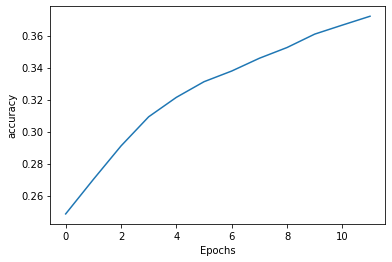

In [ ]:
plot_graphs(history, 'accuracy')

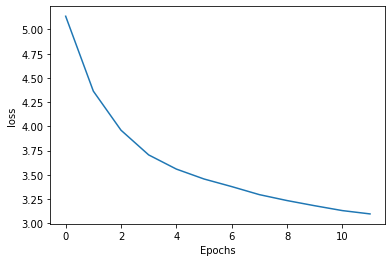

In [ ]:
plot_graphs(history, 'loss')

<a name="predict_next_word"></a>
## Predicting next word of title - throuth word_pieces

In [ ]:
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}
vocab_size = sp.vocab_size()

In [ ]:
sp.id_to_piece(4), sp.id_to_piece(20)

('s', '?')

In [ ]:
seed_text = "implementation of"
seed_text = "implementation of a fear"
seed_text = "how to"
seed_text = "How to Use"
seed_text = "Databricks: How to Save File"
seed_text = "How to Save File"
next_words = 2
max_pieces = 20

output_words = ""

for _ in range(next_words):
    #token_list = tokenizer.texts_to_sequences([seed_text])[0]
    output_word = ""
    last_piece_is_beg_of_word = False
    for i in range(max_pieces):
        token_list = sp.encode_as_ids(seed_text + output_word.replace('_',' '))
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted_probs = model.predict(token_list, verbose=0)
        #print(predicted_probs.shape)
        predicted = np.argmax(predicted_probs)
        #print(predicted)
        #output_word = sp.id_to_piece(predicted)
        output_piece = sp.id_to_piece(int(predicted))
        print(predicted, output_piece)
        if output_piece.endswith("▁") or output_piece.endswith("[EOS]"):
            output_word += output_piece.replace('▁',' ')
            break
        elif last_piece_is_beg_of_word and output_piece.find('▁')>-1:
            output_word += output_piece.replace('▁',' ')
            break
        else:
            output_word += output_piece.replace('▁',' ')
            if output_piece.find('▁')>-1:
                last_piece_is_beg_of_word = True
        print(i, f"output_word: {output_word}")
    output_words += " " + output_word.replace('▁',' ')
    print(i, f"output_words: {output_words}")

print(seed_text + output_words)

4 s
0 output_word: s
89 ▁About
1 output_word: s About
24 ▁Your
2 output_words:  s About Your
4 s
0 output_word: s
89 ▁About
1 output_word: s About
24 ▁Your
2 output_words:  s About Your s About Your
How to Save File s About Your s About Your


<a name="SentencePiece"></a>
# **with SentencePiece - v II - Vocab_size=1000**

## Setup & Import

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.7 MB/s 


In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import sentencepiece as spm

## Data prepare

#### Load data

In [ ]:
data_link = "https://drive.google.com/file/d/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8/view?usp=sharing"
file_id= data_link.split('/')[-2]
fn = 'medium_data.csv'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=''$file_id' -O '$fn'


--2022-06-02 16:02:47--  https://docs.google.com/uc?export=download&id=1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8
Resolving docs.google.com (docs.google.com)... 142.251.107.113, 142.251.107.139, 142.251.107.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ad7or30hcd35ars5dndq0oo1g5s2dbpl/1654185750000/17304979608001708681/*/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8?e=download [following]
--2022-06-02 16:02:48--  https://doc-14-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ad7or30hcd35ars5dndq0oo1g5s2dbpl/1654185750000/17304979608001708681/*/1vQbu1XmenVtNYSvqZmiwAo2jzFWZCsI8?e=download
Resolving doc-14-b0-docs.googleusercontent.com (doc-14-b0-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-14-b0-docs.googleusercontent.com (doc-14-b0-docs

In [ ]:
#medium_data = pd.read_csv('../input/medium-articles-dataset/medium_data.csv') # Kaggle
medium_data = pd.read_csv('medium_data.csv') # Colab
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


<a name="remv"></a>
#### Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.lower())

In [ ]:
medium_data['title'].to_csv('medium_data.txt', index=False, header=None )

```
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])
```

<a name="token"></a>
#### Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [ ]:
# by example https://colab.research.google.com/github/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb#scrollTo=ee9W6wGnVteW
# by End-to-End ASR SpeechBrain
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")

#import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()


In [ ]:
#spm.SentencePieceTrainer.train('--input=botchan.txt --vocab_size=2000 --model_prefix=m --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]')
#spm.SentencePieceTrainer.train('--input=medium_data.txt --vocab_size=9000 --model_prefix=m --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]')
spm.SentencePieceTrainer.train('--input=medium_data.txt --vocab_size=1000 --model_prefix=tokenizer --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]')
sp = spm.SentencePieceProcessor()
sp.load('tokenizer.model')

# <unk>=0, <s>=1, </s>=2, <sep>=3, <cls>=4
print('bos=', sp.bos_id())
print('eos=', sp.eos_id())
print('unk=', sp.unk_id())
print('pad=', sp.pad_id())  # disabled by default

for id in range(4):
    print(sp.id_to_piece(id), sp.is_control(id))
vocab_size = sp.vocab_size()
print(f"vocab_size={vocab_size}")
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}

bos= 2
eos= 3
unk= 1
pad= 0
[PAD] True
[UNK] False
[BOS] True
[EOS] True
vocab_size=1000


In [ ]:
sp.id_to_piece(0), sp.id_to_piece(1), sp.id_to_piece(199), sp.id_to_piece(999), sp.decode_ids([999])

('[PAD]', '[UNK]', 'qu', '“', '“')

In [ ]:

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))


['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
[5, 1, 5, 1, 5, 1, 5, 1]
['▁', 'ИЗ', '▁', 'СТОРОНЫ', '▁', 'В', '▁', 'СТОРОНУ', '▁', 'ОЩУЩЕНИЕ', '▁', 'КОТОРОГО', '▁', 'ОН', '▁', 'НИКОГДА']
[5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1]


In [ ]:
input_sequences = []
for c, line in enumerate(medium_data['title']):
    #token_list = tokenizer.texts_to_sequences([line])[0]
    token_list = sp.encode_as_ids(line) #[0]
    if c< 2: print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

    if c< 2: print(input_sequences)
print("Total input sequences: ", len(input_sequences))

[9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8, 45, 456, 4, 28, 27, 459, 232, 117, 41, 241]
[[9, 568], [9, 568, 18], [9, 568, 18, 4], [9, 568, 18, 4, 213], [9, 568, 18, 4, 213, 7], [9, 568, 18, 4, 213, 7, 459], [9, 568, 18, 4, 213, 7, 459, 5], [9, 568, 18, 4, 213, 7, 459, 5, 129], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8, 45], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8, 45, 456], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8, 45, 456, 4], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8, 45, 456, 4, 28], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8, 45, 456, 4, 28, 27], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8, 45, 456, 4, 28, 27, 459], [9, 568, 18, 4, 213, 7, 459, 5, 129, 40, 49, 14, 8, 45, 456, 4, 28, 27, 459, 232], [9, 568, 18, 4, 213, 7, 459, 5, 129,

In [ ]:
medium_data['title'][0]

'a beginner’s guide to word embedding with gensim word2vec model'

In [ ]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(input_sequences[1])
print(max_sequence_len)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   9
 568  18]
164


<a name="xy_2"></a>
## Prepare features and labels

Here, we consider **last element of all sequences as a label**.Then,
We need to perform **onehot encoding on labels corresponding to total_words.**

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
#ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
ys = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

In [ ]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   9 568  18   4 213
   7]
459
0.0


In [ ]:
sp.id_to_piece(26),  sp.id_to_piece(777), sp.id_to_piece(13), sp.id_to_piece(4), sp.id_to_piece(133), sp.id_to_piece(5) 

(':', '▁past', '▁in', 's', '▁work', '▁')

<a name="train_2"></a>
## Bi- LSTM Neural Network Model training

### p1 - fst 3 epochs

In [ ]:
model = Sequential()
#model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Embedding(vocab_size, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
#model.add(Dense(total_words, activation='softmax'))
model.add(Dense(vocab_size, activation='softmax'))
#adam = Adam(lr=0.01)
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])



In [ ]:
history = model.fit(xs, ys, epochs=1, verbose=1)
#print model.summary()
#print(model)

```
 43/3161 [..............................] - ETA: 27:05 - loss: 6.4714 - accuracy: 0.0371
 ```